In [54]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.special as sp
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.cross_validation import StratifiedKFold

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.preprocessing import label_binarize

In [2]:
clinical_all = pd.read_csv('./s_data/crc_clinical_sheet.txt', delimiter='\t')

In [3]:
clinical_all.anatomic_organ_subdivision.value_counts()

Sigmoid Colon            78
Rectum                   70
Cecum                    40
Ascending Colon          38
Transverse Colon         18
Hepatic Flexure          13
Descending Colon          7
Rectosigmoid Junction     4
Splenic Flexure           2
Name: anatomic_organ_subdivision, dtype: int64

In [4]:
clinical_all.tumor_site.value_counts(dropna=False)

1 - right colon         92
3 - left colon          86
4 - rectum              75
2 - transverse colon    18
NaN                      5
Name: tumor_site, dtype: int64

In [5]:
meth = pd.read_csv('./s_data/crc_methylation_datamatrix.tsv', delimiter='\t')
meth = meth.T
meth.columns = meth.loc['Composite',:]
meth.drop(['Composite','Gene','Chr','Coordinate'], axis=0, inplace=True)
print meth.shape
meth.head()

(279, 27578)


Composite,cg00000292,cg00002426,cg00003994,cg00005847,cg00006414,cg00007981,cg00008493,cg00008713,cg00009407,cg00010193,...,cg27653134,cg27654142,cg27655855,cg27655905,cg27657249,cg27657283,cg27661264,cg27662379,cg27662877,cg27665659
TCGA-A6-2670-01A-02D-0820-05,0.671988,0.828279,0.0498237,0.738021,NaN,0.0321543,0.983954,0.0168222,0.0131904,0.646338,...,0.228385,0.0253934,NaN,0.0234933,NaN,0.0313165,0.271392,0.0104046,0.0159873,0.0249181
TCGA-A6-2672-01A-01D-0825-05,0.762135,0.890454,0.357462,0.593428,NaN,0.0457143,0.978746,0.0174008,0.0148989,0.72084,...,0.615684,0.0478772,NaN,0.0661902,NaN,0.0430005,0.558802,0.0159546,0.0224303,0.0293738
TCGA-A6-2672-11A-01D-1551-05,0.505072,0.523734,0.0930745,0.391878,NaN,0.0863047,0.966664,0.0544038,0.0292515,0.53111,...,0.711352,0.0409017,NaN,0.0802444,NaN,0.13327,0.195272,0.0336064,0.0985896,0.0826947
TCGA-A6-2674-01A-02D-0820-05,0.591515,0.412918,0.18422,0.39337,NaN,0.0206652,0.981815,0.0133196,0.00821306,0.646899,...,0.461821,0.0460494,NaN,0.030738,NaN,0.0353974,0.304018,0.00912833,0.0152938,0.0202024
TCGA-A6-2674-11A-01D-1551-05,0.496904,0.286871,0.152853,0.557574,NaN,0.0954693,0.965901,0.0502751,0.0337617,0.551454,...,0.423388,0.0786659,NaN,0.0445212,NaN,0.144899,0.153203,0.0298076,0.0806372,0.0334157


### Data cleaning

In [6]:
# drop coloumns & rows which have nan in more than 50% instances
meth = meth.dropna(axis=1, thresh = 0.5*meth.shape[0]) # for columns
meth = meth.dropna(axis=0, thresh = 0.5*meth.shape[1]) # for rows
meth_col = meth.columns.tolist()
meth_index = meth.index.tolist()
print meth.shape
# Fill nan with the median values
fill_NaN = Imputer(missing_values=np.nan, strategy='median', axis=1)
meth =  pd.DataFrame(fill_NaN.fit_transform(meth), index=meth_index)
meth.columns = meth_col
meth.head()

(278, 23094)


,cg00000292,cg00002426,cg00003994,cg00005847,cg00007981,cg00008493,cg00008713,cg00009407,cg00010193,cg00011459,...,cg27651218,cg27652350,cg27653134,cg27654142,cg27655905,cg27657283,cg27661264,cg27662379,cg27662877,cg27665659
TCGA-A6-2670-01A-02D-0820-05,0.671988,0.828279,0.049824,0.738021,0.032154,0.983954,0.016822,0.013190,0.646338,0.960835,...,0.977442,0.815007,0.228385,0.025393,0.023493,0.031316,0.271392,0.010405,0.015987,0.024918
TCGA-A6-2672-01A-01D-0825-05,0.762135,0.890454,0.357462,0.593428,0.045714,0.978746,0.017401,0.014899,0.720840,0.957934,...,0.972605,0.679791,0.615684,0.047877,0.066190,0.043001,0.558802,0.015955,0.022430,0.029374
TCGA-A6-2672-11A-01D-1551-05,0.505072,0.523734,0.093074,0.391878,0.086305,0.966664,0.054404,0.029252,0.531110,0.843958,...,0.940022,0.560943,0.711352,0.040902,0.080244,0.133270,0.195272,0.033606,0.098590,0.082695
TCGA-A6-2674-01A-02D-0820-05,0.591515,0.412918,0.184220,0.393370,0.020665,0.981815,0.013320,0.008213,0.646899,0.969090,...,0.881007,0.545712,0.461821,0.046049,0.030738,0.035397,0.304018,0.009128,0.015294,0.020202
TCGA-A6-2674-11A-01D-1551-05,0.496904,0.286871,0.152853,0.557574,0.095469,0.965901,0.050275,0.033762,0.551454,0.869028,...,0.915341,0.227608,0.423388,0.078666,0.044521,0.144899,0.153203,0.029808,0.080637,0.033416


### Data munging

In [7]:
# convert beta-values to M-values usint logit transformation
# since logit(0) is minus infinity convert all beta values that are zero to 0.0001

meth_mval = meth.replace(0, 0.0001)
meth_mval = meth_mval.applymap(lambda x : sp.logit(x))

# scale the mvalues 
def featureScaling(x):
    ub = 4
    lb = -6
    x_scale = (x - lb) / (ub - lb)
    x_scale = 0 if x_scale < 0 else x_scale
    x_scale = 1 if x_scale > 1 else x_scale
    return float(x_scale)

meth_mval = meth_mval.applymap(lambda x: featureScaling(x))

In [8]:
meth_bval = meth.copy()

meth_bval['patient'] = meth_bval.index.tolist()
meth_bval['patient'] = meth_bval['patient'].apply(lambda x : x[0:12])

meth_mval['patient'] = meth_mval.index.tolist()
meth_mval['patient'] = meth_mval['patient'].apply(lambda x : x[0:12])
meth_mval.head()

,cg00000292,cg00002426,cg00003994,cg00005847,cg00007981,cg00008493,cg00008713,cg00009407,cg00010193,cg00011459,...,cg27652350,cg27653134,cg27654142,cg27655905,cg27657283,cg27661264,cg27662379,cg27662877,cg27665659,patient
TCGA-A6-2670-01A-02D-0820-05,0.671719,0.757348,0.305184,0.703571,0.259547,1.000000,0.193191,0.168501,0.660298,0.920001,...,0.748288,0.478254,0.235245,0.227273,0.256821,0.501243,0.144495,0.188016,0.233307,TCGA-A6-2670
TCGA-A6-2672-01A-01D-0825-05,0.716442,0.809539,0.541360,0.637815,0.296145,0.982973,0.196631,0.180854,0.694863,0.912554,...,0.675281,0.647127,0.300995,0.335326,0.289741,0.623630,0.187807,0.222534,0.250216,TCGA-A6-2672
TCGA-A6-2672-11A-01D-1551-05,0.602029,0.609501,0.372334,0.556057,0.364039,0.936721,0.314462,0.249787,0.612460,0.768798,...,0.624499,0.690196,0.284518,0.356097,0.412765,0.458389,0.264115,0.378701,0.359371,TCGA-A6-2672
TCGA-A6-2674-01A-02D-0820-05,0.637023,0.564809,0.451199,0.556683,0.214158,0.998879,0.169489,0.120622,0.660544,0.944528,...,0.618336,0.584699,0.296910,0.254897,0.269492,0.517176,0.131280,0.183510,0.211846,TCGA-A6-2674
TCGA-A6-2674-11A-01D-1551-05,0.598762,0.508937,0.428760,0.623132,0.375139,0.934380,0.306134,0.264592,0.620655,0.789239,...,0.477813,0.569112,0.353939,0.293375,0.422482,0.429030,0.251727,0.356628,0.263526,TCGA-A6-2674


In [9]:
# Extract colorectal-cancer tumor site information 

location = clinical_all[['patient','tumor_site']]
location = location.dropna(axis=0)
location['class'] = location['tumor_site'].str.split('-').str[0].astype(np.int64)

# merge location and methylation data
crc_bval = pd.merge(location, meth_bval, on='patient', how='inner')
crc_mval = pd.merge(location, meth_mval, on='patient', how='inner')

crc_bval.drop(['patient','tumor_site'], axis=1, inplace=True)
crc_mval.drop(['patient','tumor_site'], axis=1, inplace=True)

# colon only 
colon_mval = crc_mval[crc_mval['class'] != 4]
colon_bval = crc_bval[crc_bval['class'] != 4]

In [10]:
location['tumor_site'].value_counts(dropna=False)

1 - right colon         92
3 - left colon          86
4 - rectum              75
2 - transverse colon    18
Name: tumor_site, dtype: int64

In [11]:
crc_bval.head()

,class,cg00000292,cg00002426,cg00003994,cg00005847,cg00007981,cg00008493,cg00008713,cg00009407,cg00010193,...,cg27651218,cg27652350,cg27653134,cg27654142,cg27655905,cg27657283,cg27661264,cg27662379,cg27662877,cg27665659
0,3,0.671988,0.828279,0.049824,0.738021,0.032154,0.983954,0.016822,0.013190,0.646338,...,0.977442,0.815007,0.228385,0.025393,0.023493,0.031316,0.271392,0.010405,0.015987,0.024918
1,2,0.762135,0.890454,0.357462,0.593428,0.045714,0.978746,0.017401,0.014899,0.720840,...,0.972605,0.679791,0.615684,0.047877,0.066190,0.043001,0.558802,0.015955,0.022430,0.029374
2,2,0.505072,0.523734,0.093074,0.391878,0.086305,0.966664,0.054404,0.029252,0.531110,...,0.940022,0.560943,0.711352,0.040902,0.080244,0.133270,0.195272,0.033606,0.098590,0.082695
3,3,0.591515,0.412918,0.184220,0.393370,0.020665,0.981815,0.013320,0.008213,0.646899,...,0.881007,0.545712,0.461821,0.046049,0.030738,0.035397,0.304018,0.009128,0.015294,0.020202
4,3,0.496904,0.286871,0.152853,0.557574,0.095469,0.965901,0.050275,0.033762,0.551454,...,0.915341,0.227608,0.423388,0.078666,0.044521,0.144899,0.153203,0.029808,0.080637,0.033416


### Machine Learning

In [64]:
def svc_linear(df,features,c_val=None):
    X = df[features]
    y = df['class']
    
    c_val = 1 if c_val is 'None' else c_val
    
    clf = LinearSVC(C=c_val)
    
    #cv_scores = cross_val_score(clf, X, y)
    #print('\n3-fol Cross validation\n')
    #print('Cross-validation scores: %0.3f %0.3f %0.3f' %(cv_scores[0],cv_scores[1],cv_scores[2]))
    #print('Mean cross-validation score (3-fold): {:.3f}' .format(np.mean(cv_scores)))
    
    print('\nRegular train-test split\n')

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
    clf = LinearSVC(C=c_val).fit(X_train, y_train)
    print('Accuracy of Linear SVC classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
    print('Accuracy of Linear SVC classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))
    
    return


def svc_linear_Kfold(df,features,c_val=None):
    X = df[features]
    y = df['class']
    
    c_val = 1 if c_val is 'None' else c_val
    
    X1=X.values
    y1=y.values
    total_elem = len(y1)
    kf = cross_validation.KFold(total_elem, n_folds=5)
    print "Results of %d fold cross-validation (KFold)\n" % len(kf)

    for k, (train_index, test_index) in enumerate(kf):
        X_train, X_test = X1[train_index], X1[test_index]
        y_train, y_test = y1[train_index], y1[test_index]
        clf = LinearSVC(C=c_val).fit(X_train, y_train)
        accuracy_test = clf.score(X_test, y_test)
        accuracy_train = clf.score(X_train, y_train)
        print ('Accuracy of training set: %0.3f Accuracy of test set: %0.3f' %(accuracy_train, accuracy_test))
    
    return

def svc_linear_SKfold(df,features,c_val=None):
    X = df[features]
    y = df['class']
    
    X = X.values
    y = y.values
    c_val = 1 if c_val is 'None' else c_val
    
    kf = cross_validation.StratifiedKFold(y, n_folds=3, random_state=1)
    print "Results of %d fold cross-validation (Stratified KFold)\n" % len(kf)

    train_sum = 0; test_sum=0; MCC_sum=0; F1_score_sum=0
    for k, (train_index, test_index) in enumerate(kf):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = LinearSVC(C=c_val).fit(X_train, y_train)
        accuracy_test = clf.score(X_test, y_test) ;  test_sum = test_sum + accuracy_test
        accuracy_train = clf.score(X_train, y_train) ; train_sum = train_sum + accuracy_train
        
        y_pred = clf.predict(X_test)
        F1_score = f1_score(y_test,y_pred,average='weighted') ; F1_score_sum = F1_score_sum + F1_score
        #MCC = matthews_corrcoef(y_test,y_pred) ; MCC_sum = MCC_sum + MCC
        
        print ('Fold %d ->Accuracy of training set: %0.3f Accuracy of test set: %0.3f F1-score: %0.3f' %(k, accuracy_train, accuracy_test, F1_score))
        
    print ('\nAverage accuracy of training set : %0.3f' %(train_sum/len(kf)))
    print ('Average accuracy of test set : %0.3f\n\n' %(test_sum/len(kf)))
    print ('Average F1-Score of test set : %0.3f\n\n' %(F1_score_sum/len(kf)))
    #print ('Average MCC of test set : %0.3f\n\n' %(MCC_sum/len(kf)))
    return

def convert_file2list(filename):
    input_file = open(filename,'r')
    lines1 = input_file.read().splitlines()
    input_file.close()
    out_list  = [line.rstrip('\n') for line in lines1]
    return (out_list)


In [49]:
dict_location = {1:'right',2:'transverse',3:'left',4:'rectum'}

def heatmap_confusion_matrix(df, features,c_val=None, name=None ):
    X = df[features]
    y = df['class']
    c_val = 1 if c_val is 'None' else c_val
    name = fig if name is 'None' else name
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, stratify =y)
    clf = LinearSVC(C=c_val).fit(X_train, y_train)
    
    clf_predicted = clf.predict(X_test)
    confusion_mc = confusion_matrix(y_test, clf_predicted)
    
    ## Heatmap
    
    no_class = len(df['class'].unique().tolist())
    classes = sorted(df['class'].unique().tolist())
    df_cm = pd.DataFrame(confusion_mc, 
                     index = [dict_location[i] for i in classes], columns = [dict_location[i] for i in classes])
    
    feature_length = X.shape[1]
    fig_name = "./s_figures/"+ "ConfMatrix_" + name + "_" + str(feature_length) + "_feauters.png"
    
    plt.figure(figsize=(5.5,4))
    sns.heatmap(df_cm, annot=True)
    plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test,clf_predicted)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(fig_name, dpi=300)
    print fig_name

    
    ## Classification report (reports weighted averages accross classes)
    print classification_report(y_test, clf_predicted, target_names= df_cm.columns.tolist())
    ## using other precision_recall_fscore_support fucntion 
    print precision_recall_fscore_support(y_test, clf_predicted, average='weighted')
    print precision_recall_fscore_support(y_test, clf_predicted, average='macro')
    
    return

./s_figures/ConfMatrix_colon_mval_352_feauters.png
             precision    recall  f1-score   support

      right       0.81      0.96      0.88        23
 transverse       0.00      0.00      0.00         5
       left       0.96      0.96      0.96        23

avg / total       0.80      0.86      0.83        51

(0.79883805374001449, 0.86274509803921573, 0.82823529411764707, None)
(0.59044551798174982, 0.63768115942028991, 0.61217391304347835, None)


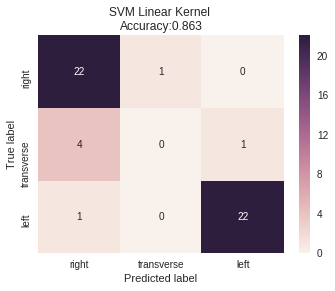

In [53]:
#list_delta = convert_file2list('./s_lists/DMG_delta0.3_cpg.lst')
list_delta = convert_file2list('./s_lists/delta_0.28.lst')
cpg_features = list(set(list_delta) & set(meth_col))

heatmap_confusion_matrix(colon_mval, cpg_features,1, 'colon_mval')

./s_figures/ConfMatrix_crc_mval_352_feauters.png
             precision    recall  f1-score   support

      right       0.81      0.91      0.86        23
 transverse       0.00      0.00      0.00         5
       left       0.61      0.74      0.67        23
     rectum       0.64      0.47      0.55        19

avg / total       0.64      0.67      0.65        70

(0.63936420722135001, 0.67142857142857137, 0.64873222016079157, None)
(0.51442307692307687, 0.53146453089244849, 0.51731601731601728, None)


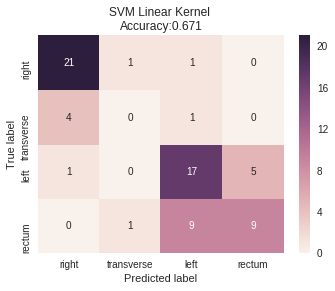

In [51]:
#list_delta = convert_file2list('./s_lists/DMG_delta0.3_cpg.lst')
list_delta = convert_file2list('./s_lists/delta_0.28.lst')
cpg_features = list(set(list_delta) & set(meth_col))

heatmap_confusion_matrix(crc_mval,cpg_features,1, 'crc_mval')

./s_figures/ConfMatrix_crc_mval_60_feauters.png
             precision    recall  f1-score   support

      right       0.73      0.96      0.83        23
 transverse       0.00      0.00      0.00         5
       left       0.58      0.65      0.61        23
     rectum       0.50      0.37      0.42        19

avg / total       0.57      0.63      0.59        70

(0.56622710622710615, 0.62857142857142856, 0.58909397623298276, None)
(0.45256410256410251, 0.49427917620137302, 0.46666900036172276, None)


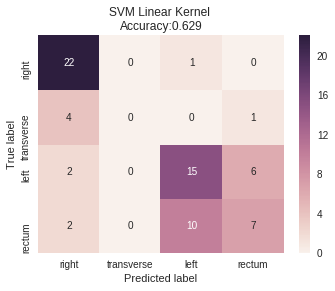

In [52]:
list_delta = convert_file2list('./s_lists/delta_0.28.lst')
cpg_features = list(set(list_delta) & set(meth_col))

heatmap_confusion_matrix(crc_mval,cpg_features,1, 'crc_mval')

In [75]:
print len(crc_mval['class'].unique().tolist())+1
dict_location = {1:'right',2:'transverse',3:'left',4:'rectum'}
dict_location[1.0]
sorted(crc_mval['class'].unique().tolist())

5


[1.0, 2.0, 3.0, 4.0]

In [59]:
## For colon + rectum cancer locations using all Cpg islands

print "\n** Data : CRC , Meth : M-values ** \n"
svc_linear_SKfold(crc_mval,meth_col,5)

print "\n** Data : CRC , Meth : B-values ** \n"
svc_linear_SKfold(crc_bval,meth_col,5)


** Data : CRC , Meth : M-values ** 

Results of 3 fold cross-validation (Stratified KFold)

Fold 0 ->Accuracy of training set: 1.000 Accuracy of test set: 0.638
Fold 1 ->Accuracy of training set: 1.000 Accuracy of test set: 0.674
Fold 2 ->Accuracy of training set: 1.000 Accuracy of test set: 0.582

Average accuracy of training set : 1.000
Average accuracy of test set : 0.632



** Data : CRC , Meth : B-values ** 

Results of 3 fold cross-validation (Stratified KFold)

Fold 0 ->Accuracy of training set: 1.000 Accuracy of test set: 0.670
Fold 1 ->Accuracy of training set: 1.000 Accuracy of test set: 0.707
Fold 2 ->Accuracy of training set: 1.000 Accuracy of test set: 0.615

Average accuracy of training set : 1.000
Average accuracy of test set : 0.664




In [65]:
## For only colon cancer location using all Cpg islands

print "\n** Data : Colon , Meth : M-values ** \n"
svc_linear_SKfold(colon_mval,meth_col,1)

#print "\n** Data : Colon , Meth : B-values ** \n"
#svc_linear_SKfold(colon_bval,meth_col,1)


** Data : Colon , Meth : M-values ** 

Results of 3 fold cross-validation (Stratified KFold)

Fold 0 ->Accuracy of training set: 1.000 Accuracy of test set: 0.750 F1-score: 0.715
Fold 1 ->Accuracy of training set: 1.000 Accuracy of test set: 0.806 F1-score: 0.773
Fold 2 ->Accuracy of training set: 1.000 Accuracy of test set: 0.773 F1-score: 0.742

Average accuracy of training set : 1.000
Average accuracy of test set : 0.776


Average F1-Score of test set : 0.743




In [77]:
# For only colon cancer
# Using CpG identified by Delta , cutoff is 0.28

list_delta = convert_file2list('./s_lists/delta_0.28.lst')
cpg_features = list(set(list_delta) & set(meth_col))

print "Number of features %d" %(len(cpg_features))
print "\n** Data : Colon , Meth : M-values ** \n"
svc_linear_SKfold(colon_mval,cpg_features,1)

Number of features 352

** Data : Colon , Meth : M-values ** 

Results of 3 fold cross-validation (Stratified KFold)

Fold 0 ->Accuracy of training set: 0.985 Accuracy of test set: 0.838 F1-score: 0.794
Fold 1 ->Accuracy of training set: 0.970 Accuracy of test set: 0.866 F1-score: 0.860
Fold 2 ->Accuracy of training set: 0.985 Accuracy of test set: 0.803 F1-score: 0.772

Average accuracy of training set : 0.980
Average accuracy of test set : 0.836


Average F1-Score of test set : 0.809




In [73]:
# For only colon cancer
# Using CpG identified by Delta , cutoff is 0.28

list_delta = convert_file2list('./s_lists/delta_0.30.lst')
cpg_features = list(set(list_delta) & set(meth_col))

print "\n** Data : Colon , Meth : M-values ** \n"
print "Number of features %d" %(len(cpg_features))
svc_linear_SKfold(colon_mval,cpg_features,1)


** Data : Colon , Meth : M-values ** 

Number of features 209
Results of 3 fold cross-validation (Stratified KFold)

Fold 0 ->Accuracy of training set: 0.977 Accuracy of test set: 0.838 F1-score: 0.794
Fold 1 ->Accuracy of training set: 0.955 Accuracy of test set: 0.836 F1-score: 0.814
Fold 2 ->Accuracy of training set: 0.956 Accuracy of test set: 0.803 F1-score: 0.765

Average accuracy of training set : 0.963
Average accuracy of test set : 0.826


Average F1-Score of test set : 0.791




In [74]:
# For colon cancer only
# Using DMG + (Delta > 0.3)

list_delta = convert_file2list('./s_lists/DMG_delta0.3_cpg.lst')
cpg_features = list(set(list_delta) & set(meth_col))

print "Number of features %d" %(len(cpg_features))
print "\n** Data : Colon , Meth : M-values ** \n"
svc_linear_SKfold(colon_mval,cpg_features,1)

Number of features 60

** Data : Colon , Meth : M-values ** 

Results of 3 fold cross-validation (Stratified KFold)

Fold 0 ->Accuracy of training set: 0.895 Accuracy of test set: 0.809 F1-score: 0.771
Fold 1 ->Accuracy of training set: 0.910 Accuracy of test set: 0.791 F1-score: 0.771
Fold 2 ->Accuracy of training set: 0.889 Accuracy of test set: 0.833 F1-score: 0.812

Average accuracy of training set : 0.898
Average accuracy of test set : 0.811


Average F1-Score of test set : 0.784




In [75]:
# For colon cancer only
# Using DMG + (Delta > 0.28)

list_delta = convert_file2list('./s_lists/DMG_delta0.28_cpg.lst')
cpg_features = list(set(list_delta) & set(meth_col))

print "Number of features %d" %(len(cpg_features))
print "\n** Data : Colon , Meth : M-values ** \n"
svc_linear_SKfold(colon_mval,cpg_features,1)

Number of features 93

** Data : Colon , Meth : M-values ** 

Results of 3 fold cross-validation (Stratified KFold)

Fold 0 ->Accuracy of training set: 0.932 Accuracy of test set: 0.824 F1-score: 0.784
Fold 1 ->Accuracy of training set: 0.910 Accuracy of test set: 0.836 F1-score: 0.814
Fold 2 ->Accuracy of training set: 0.911 Accuracy of test set: 0.833 F1-score: 0.815

Average accuracy of training set : 0.918
Average accuracy of test set : 0.831


Average F1-Score of test set : 0.804




In [76]:
len(meth_col)

23094